# Fisheries competition and other CNN tricks

In this notebook we will classify species of fish. We will be using data from the [Kaggle competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/). 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
from collections import Counter

In [2]:
import cv2
import matplotlib.pyplot as plt 

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/competitit )<br/>
`kaggle competitions download -c the-nature-conservancy-fisheries-monitoring -p /data2/yinterian/fisheries` <br/>

In [3]:
PATH = Path("/data2/yinterian/fisheries")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/fisheries/test_stg1.zip'),
 PosixPath('/data2/yinterian/fisheries/annotations'),
 PosixPath('/data2/yinterian/fisheries/model.pth'),
 PosixPath('/data2/yinterian/fisheries/__MACOSX'),
 PosixPath('/data2/yinterian/fisheries/sample_submission_stg2.csv.zip'),
 PosixPath('/data2/yinterian/fisheries/mode_tmp.pth'),
 PosixPath('/data2/yinterian/fisheries/test_stg2.7z'),
 PosixPath('/data2/yinterian/fisheries/sample_submission_stg1.csv.zip'),
 PosixPath('/data2/yinterian/fisheries/train.zip'),
 PosixPath('/data2/yinterian/fisheries/train-300'),
 PosixPath('/data2/yinterian/fisheries/train'),
 PosixPath('/data2/yinterian/fisheries/bet_labels.json'),
 PosixPath('/data2/yinterian/fisheries/valid-300')]

In [4]:
list((PATH/"train").iterdir())

[PosixPath('/data2/yinterian/fisheries/train/DOL'),
 PosixPath('/data2/yinterian/fisheries/train/NoF'),
 PosixPath('/data2/yinterian/fisheries/train/LAG'),
 PosixPath('/data2/yinterian/fisheries/train/SHARK'),
 PosixPath('/data2/yinterian/fisheries/train/OTHER'),
 PosixPath('/data2/yinterian/fisheries/train/.DS_Store'),
 PosixPath('/data2/yinterian/fisheries/train/BET'),
 PosixPath('/data2/yinterian/fisheries/train/YFT'),
 PosixPath('/data2/yinterian/fisheries/train/ALB')]

In [5]:
list((PATH/"train"/"ALB").iterdir())[:5]

[PosixPath('/data2/yinterian/fisheries/train/ALB/img_02140.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_04320.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_06727.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_06086.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_04377.jpg')]

In [6]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

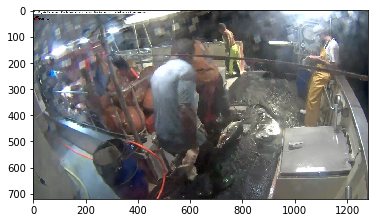

In [7]:
path = PATH/"train/ALB/img_02140.jpg"
im = read_image(path)
plt.imshow(im)

In [8]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(720, 1280, 3)

In [9]:
# let's look at the typical size of these images
files = list((PATH/"train/ALB/").iterdir()) + list((PATH/"train/SHARK/").iterdir())
dims = [read_image(str(p)).shape for p in files]
counts = Counter(dims)
counts

Counter({(720, 1280, 3): 1163,
         (854, 1518, 3): 6,
         (670, 1192, 3): 164,
         (750, 1280, 3): 330,
         (974, 1280, 3): 87,
         (718, 1276, 3): 109,
         (924, 1280, 3): 34,
         (700, 1244, 3): 2})

In [10]:
[(k[1]/k[0], counts[k]) for k in counts] 

[(1.7777777777777777, 1163),
 (1.7775175644028103, 6),
 (1.7791044776119402, 164),
 (1.7066666666666668, 330),
 (1.3141683778234086, 87),
 (1.777158774373259, 109),
 (1.3852813852813852, 34),
 (1.7771428571428571, 2)]

## Resizing images

In [11]:
paths = sorted([x for x in list((PATH/"train").iterdir()) if x.is_dir()])
paths

[PosixPath('/data2/yinterian/fisheries/train/ALB'),
 PosixPath('/data2/yinterian/fisheries/train/BET'),
 PosixPath('/data2/yinterian/fisheries/train/DOL'),
 PosixPath('/data2/yinterian/fisheries/train/LAG'),
 PosixPath('/data2/yinterian/fisheries/train/NoF'),
 PosixPath('/data2/yinterian/fisheries/train/OTHER'),
 PosixPath('/data2/yinterian/fisheries/train/SHARK'),
 PosixPath('/data2/yinterian/fisheries/train/YFT')]

In [12]:
## all files
files = [f for d in paths for f in list(d.iterdir())]
len(files)
files[-3:]

[PosixPath('/data2/yinterian/fisheries/train/YFT/img_00783.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/YFT/img_02756.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/YFT/img_05644.jpg')]

In [13]:
# here is how you get the class
files[0].parts[-2]

'ALB'

In [14]:
labels = [p.parts[-1] for p in paths]
labels

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [15]:
{v:k for k, v in enumerate(labels)}

{'ALB': 0,
 'BET': 1,
 'DOL': 2,
 'LAG': 3,
 'NoF': 4,
 'OTHER': 5,
 'SHARK': 6,
 'YFT': 7}

In [16]:
def resize_images(path, sz=300):
    im = read_image(path)
    sz2 = int(1.778*sz)
    return cv2.resize(im, (sz2, sz))

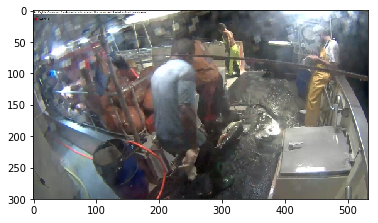

In [17]:
path = PATH/"train/ALB/img_02140.jpg"
im = resize_images(path)
plt.imshow(im)

In [18]:
train_path = PATH/"train-300"
valid_path = PATH/"valid-300"

train_path.mkdir(exist_ok=True)
valid_path.mkdir(exist_ok=True) 

In [19]:
def resize_all_images(train_path, valid_path, org_path, sz=300):
    np.random.seed(3)
    paths = [x for x in list(org_path.iterdir()) if x.is_dir()]
    for p in paths:
        label = p.parts[-1]
        (train_path/label).mkdir(exist_ok=True)
        (valid_path/label).mkdir(exist_ok=True) 
        files = list((org_path/label).iterdir())
        for f in files:
            f_name = f.parts[-1]
            if np.random.uniform() < 0.8:
                new_path = train_path/label/f_name
            else:
                new_path = valid_path/label/f_name
            im = resize_images(f)
            cv2.imwrite(str(new_path), cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

In [20]:
#run just the first time
#resize_all_images(train_path, valid_path, PATH/"train")

In [21]:
# checking
for label in labels:
    all_files = len(list((PATH/"train"/label).iterdir()))
    train_files = len(list((train_path/label).iterdir()))
    valid_files = len(list((valid_path/label).iterdir()))
    print(label, all_files, train_files, valid_files)

ALB 1719 1377 342
BET 200 161 39
DOL 117 100 17
LAG 67 61 6
NoF 465 373 92
OTHER 299 233 66
SHARK 176 145 31
YFT 734 587 147


## Data augmentation
Data augmentation is the most important way to avoid overfitting for image classification tasks. For this problem we cannot crop much because we may leave the fish out.

In [22]:
# modified from fast.ai
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Resize, horizontal and vertical translations

(300, 533, 3)


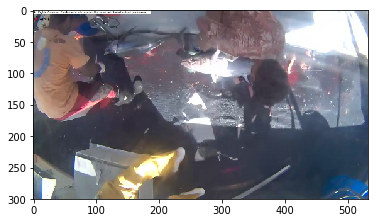

In [23]:
path = PATH/"train-300/ALB/img_03017.jpg"
im = read_image(path)
ratio = 1.778
sz1 = 280
sz2 = int(ratio*sz1)
im2 = random_crop(im, sz1, sz2)
plt.imshow(im)
print(im.shape)

(280, 497, 3)

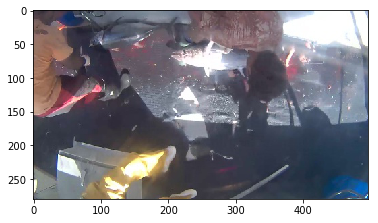

In [24]:
plt.imshow(im2)
im2.shape

### Random Rotation (-10, 10) 

-2.9355778935443078


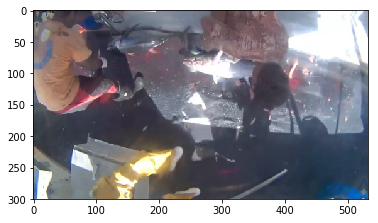

In [25]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot)

### Horizontal Flip

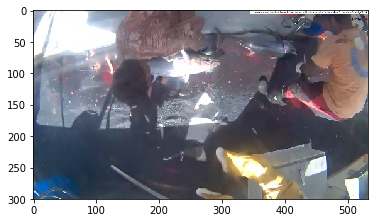

In [26]:
im_f = np.fliplr(im)
plt.imshow(im_f)

## Dataset

In [27]:
def resize_images_ratio(im, sz=300, r=1.778):
    sz2 = int(r*sz)
    return cv2.resize(im, (sz2, sz))

In [28]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [29]:
class FishDataset(Dataset):
    def __init__(self, PATH, train="train-300", transforms=False, sz=280):
        self.path_to_images = PATH/train
        self.transforms = transforms
        self.sz = sz
        self.sz2 = int(self.sz*1.778)
        self.paths = sorted([x for x in list(self.path_to_images.iterdir()) if x.is_dir()])
        self.files = [f for d in self.paths for f in list(d.iterdir())]
        self.labels = [p.parts[-1] for p in paths]
        self.label2ind = {v:k for k,v in enumerate(self.labels)}
        self.len = len(self.files)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        path = self.files[idx] 
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        # center crop
        if self.transforms:
            # assumes original images are 300x533 otherwise resize here.
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
            x = random_crop(x, self.sz, self.sz2)
        else:
            x = resize_images_ratio(x, self.sz)
        # substract numbers from resnet34
        x = normalize(x)
        y = self.label2ind[path.parts[-2]]
        return np.rollaxis(x, 2), y

In [30]:
train_ds = FishDataset(PATH, "train-300", transforms=True)
valid_ds = FishDataset(PATH, "valid-300")

In [31]:
len(train_ds), len(valid_ds)

(3037, 740)

In [32]:
batch_size = 10
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [33]:
# run this multiple times to get different images
x, y = train_ds[0]
#plt.imshow(np.rollaxis(x1, 2), cmap='gray')

In [34]:
x.shape,y

((3, 280, 497), 0)

In [35]:
x,y = next(iter(valid_dl))
x.shape

torch.Size([10, 3, 280, 497])

In [36]:
x, y = valid_ds[0]
x.shape

(3, 280, 497)

## Model

In [37]:
resnet = models.resnet34(pretrained=True)
#resnet 

In [208]:
class Net(nn.Module):
    def __init__(self, num_classes=8):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        #x = nn.Dropout(0.1)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        #x = nn.Dropout(0.1)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [190]:
model = Net().cuda()

In [191]:
x, y = next(iter(train_dl))
x.shape, y.shape

(torch.Size([64, 3, 280, 497]), torch.Size([64]))

In [192]:
x = x.cuda().float()
y = y.cuda()

In [193]:
x_features = model.top_model(x)
x_features.shape

torch.Size([64, 512, 9, 16])

In [194]:
# AdaptiveAvgPool2d would do a similar job if the input is [64, 512, 10, 20]
# that is why this model will fit any input size
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)
x_features_ave.shape

torch.Size([64, 512, 1, 1])

In [195]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([64, 512])

In [196]:
y_hat = model(x)
y_hat.shape

torch.Size([64, 8])

In [197]:
y.shape

torch.Size([64])

In [198]:
_, pred = torch.max(y_hat, 1)
pred

tensor([ 7,  5,  4,  4,  2,  0,  2,  5,  6,  0,  1,  3,  6,  7,
         1,  1,  2,  5,  3,  2,  7,  5,  0,  2,  0,  5,  4,  4,
         1,  6,  2,  7,  3,  2,  7,  3,  2,  7,  5,  2,  2,  7,
         7,  0,  3,  6,  5,  4,  1,  4,  6,  6,  0,  7,  7,  7,
         3,  6,  0,  0,  3,  6,  3,  2], device='cuda:0')

In [199]:
y

tensor([ 0,  5,  0,  0,  7,  0,  0,  7,  0,  0,  6,  3,  0,  0,
         6,  0,  1,  0,  7,  0,  7,  2,  0,  0,  6,  0,  0,  0,
         7,  0,  2,  0,  5,  0,  0,  5,  4,  7,  0,  0,  7,  0,
         4,  7,  4,  4,  7,  4,  0,  0,  0,  7,  7,  0,  0,  0,
         0,  3,  5,  0,  0,  0,  7,  0], device='cuda:0')

In [200]:
pred.eq(y).sum()

tensor(10, device='cuda:0')

In [201]:
# This loss combines a Sigmoid layer and the BCELoss in one single class. see
# https://pytorch.org/docs/master/nn.html#torch.nn.BCEWithLogitsLoss
F.cross_entropy(y_hat, y).item()

2.110316276550293

## Learning rate finder

In [175]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [176]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-6, lr_high=0.4, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x,y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses 

In [177]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [178]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl)

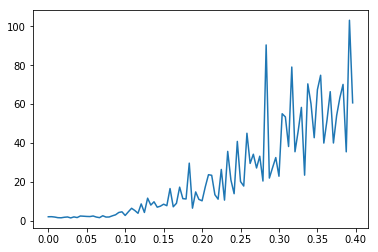

In [179]:
plt.plot(lrs, losses)
plt.show()

## Triangular learning rate training

In [180]:
def get_triangular_lr2(lr_low, lr_high, stepesize):
    iterations = 2*stepesize
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

In [181]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-5, lr_high=0.01):
    idx = 0
    epochs = 4
    stepesize = 2*len(train_dl)
    lrs = get_triangular_lr2(lr_low, lr_high, stepesize)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss %.3f" % (sum_loss/total))
        val_metrics(model, valid_dl)
    return sum_loss/total

In [182]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))

## Training with triangular rates

In [183]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, steps=3, lr_low=1e-5, lr_high=0.01):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [202]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [203]:
model = Net().cuda()

In [204]:
val_metrics(model, valid_dl)

val loss 2.082 and accuracy 0.091


In [205]:
training_loop(model, train_dl, valid_dl, steps=1)

train loss 1.365
val loss 1.016 and accuracy 0.645
train loss 0.853
val loss 0.772 and accuracy 0.732
train loss 0.536
val loss 0.515 and accuracy 0.822
train loss 0.417
val loss 0.483 and accuracy 0.824
----End of step Time elapsed 0:03:35.116512


In [206]:
training_loop(model, train_dl, valid_dl, steps=1, lr_low=1e-6, lr_high=0.005)

train loss 0.416
val loss 0.465 and accuracy 0.850
train loss 0.429
val loss 0.474 and accuracy 0.843
train loss 0.364
val loss 0.446 and accuracy 0.859
train loss 0.317
val loss 0.455 and accuracy 0.846
----End of step Time elapsed 0:03:30.719697


In [207]:
training_loop(model, train_dl, valid_dl, steps=1, lr_low=1e-6, lr_high=0.005)

train loss 0.322
val loss 0.436 and accuracy 0.858
train loss 0.348
val loss 0.427 and accuracy 0.865
train loss 0.313
val loss 0.394 and accuracy 0.874
train loss 0.256
val loss 0.363 and accuracy 0.884
----End of step Time elapsed 0:03:27.781942


## Unfreezing layers

In [76]:
# save model
def save_model(m, p): 
    torch.save(m.state_dict(), p)
p = PATH/"model-93.pth"
save_model(model, p)

In [73]:
# load model
#p = PATH/"model.pth"
model.load_state_dict(torch.load(p))

In [74]:
val_metrics(model, valid_dl)

val loss 0.211 and accuracy 0.936


In [75]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [77]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [78]:
unfreeze(model, 7)
unfreeze(model, 6)

In [79]:
train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-6, lr_high=1e-4)

train loss 0.104
val loss 0.303 and accuracy 0.920
train loss 0.133
val loss 0.233 and accuracy 0.942
train loss 0.057
val loss 0.138 and accuracy 0.957
train loss 0.030
val loss 0.128 and accuracy 0.965


0.030168927986399297

In [80]:
p = PATH/"model-96.pth"
save_model(model, p)

In [81]:
train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-7, lr_high=1e-4)

train loss 0.032
val loss 0.430 and accuracy 0.912
train loss 0.066
val loss 0.282 and accuracy 0.939
train loss 0.035
val loss 0.141 and accuracy 0.965
train loss 0.018
val loss 0.136 and accuracy 0.969


0.01832549062986534

## Bounding boxes and multi-task learning
A kaggle user has created bounding boxes for each fish in the training set. [Here](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/discussion/25902) is a link to download them. We will use the bounding boxes by training a model to not only predict the class of the fish but also the bounding box.

### Getting bounding boxes map

In [82]:
import ujson as json
import requests

In [83]:
url_prefix = 'https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/'
annot_urls = {
        '5458/bet_labels.json': 'bd20591439b650f44b36b72a98d3ce27',
        '5459/shark_labels.json': '94b1b3110ca58ff4788fb659eda7da90',
        '5460/dol_labels.json': '91a25d29a29b7e8b8d7a8770355993de',
        '5461/yft_labels.json': '9ef63caad8f076457d48a21986d81ddc',
        '5462/alb_labels.json': '731c74d347748b5272042f0661dad37c',
        '5463/lag_labels.json': '92d75d9218c3333ac31d74125f2b380a'
    }

In [84]:
# download annotations
def download_annotations():
    anno_dir = PATH/"annotations"
    anno_dir.mkdir(exist_ok=True)
    for url_suffix in annot_urls:
        url = url_prefix + url_suffix
        r = requests.get(url, allow_redirects=True)
        json_file = url_suffix.split("/")[1]
        open(anno_dir/json_file, 'wb').write(r.content)
#download_annotations()

In [85]:
jfiles = list((PATH/"annotations").iterdir())
jfiles

[PosixPath('/data2/yinterian/fisheries/annotations/shark_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/yft_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/alb_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/lag_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/bet_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/dol_labels.json')]

In [86]:
bb_json = {}
jfiles = list((PATH/"annotations").iterdir())
for f in jfiles:
    j = json.load(open(f, 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

In [87]:
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [371]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [408]:
def get_Y(path, label2ind):
    """Given an image path get y"""
    im_name = path.parts[-1]
    im_class = label2ind[path.parts[-2]]
    if im_name in bb_json:
        x = bb_json[im_name]
        return np.array([x['y'], x['x'], x['y'] + x['height'], x['x']+ x['width'], im_class])
    return np.array([0.0, 0.0, 0.0, 0.0, im_class])

In [409]:
def get_bb(files, label2ind):
    return [get_Y(p, label2ind) for p in files]

### Transfoms with bounding boxes

In [348]:
def make_bb_px(y, x):
    """ Makes an image of size x retangular bounding box"""
    r,c,*_ = x.shape
    Y = np.zeros((r, c))
    y = y.astype(np.int)
    Y[y[0]:y[2], y[1]:y[3]] = 1.
    return Y

def to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [349]:
def resize_images_ratio(im, sz=300, r=1.778):
    sz2 = int(r*sz)
    return cv2.resize(im, (sz2, sz))

In [350]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [351]:
def random_cropXY(x, Y, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    x = crop(x, start_r, start_c, target_r, target_c)
    Y = crop(Y, start_r, start_c, target_r, target_c)
    return x, Y

In [384]:
def transformsXY(path, bb, transforms, sz):
    sz2 = int(sz*1.778)
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = make_bb_px(bb, x)
    if transforms:
        x = resize_images_ratio(x, sz+20)
        Y = resize_images_ratio(Y, sz+20)
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y, sz, sz2)
    else:
        x = resize_images_ratio(x, sz)
        Y = resize_images_ratio(Y, sz)
    return x, to_bb(Y)

In [385]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [386]:
# testing
train_path=PATH/"train"
paths = [d for d in list(train_path.iterdir()) if d.is_dir()]
files = [f for d in paths for f in list(d.iterdir())]
labels = [p.parts[-1] for p in paths]
label2ind = {v:k for k,v in enumerate(labels)}
test = files[:2]

In [387]:
test

[PosixPath('/data2/yinterian/fisheries/train/DOL/img_00983.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/DOL/img_01185.jpg')]

In [388]:
bbs = get_bb(test, label2ind)

{'class': 'rect', 'height': 108.57000000000022, 'width': 258.03000000000054, 'x': 177.66000000000042, 'y': 313.02000000000066}
{'class': 'rect', 'height': 78.96000000000015, 'width': 235.47000000000048, 'x': 331.3500000000007, 'y': 420.1800000000009}


In [389]:
im = cv2.imread(str(test[1]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
bb = bbs[1][:4]
bb

array([420.18, 331.35, 499.14, 566.82])

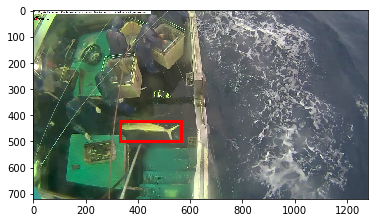

In [390]:
show_corner_bb(im, bb)

In [393]:
im, bb_t = transformsXY(str(test[1]), bb, transforms=True, sz=280)

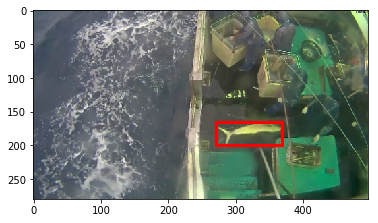

In [394]:
show_corner_bb(im, bb_t)

## New dataset
Here I have to start with the larger dataset because I need to transform x and y at the same time.

In [410]:
train_path=PATH/"train"
paths = [d for d in list(train_path.iterdir()) if d.is_dir()]
files = [f for d in paths for f in list(d.iterdir())]
labels = [p.parts[-1] for p in paths]

In [411]:
ind = np.random.rand(len(files)) < 0.8
ind_val = ind == False
train_files = np.array(files)[ind]
val_files = np.array(files)[ind_val]

In [412]:
class FishDataset2(Dataset):
    def __init__(self, files, labels, transforms=False, sz=280):
        self.transforms = transforms
        self.sz = sz
        self.files = files
        self.label2ind = {v:k for k,v in enumerate(labels)}
        self.y = get_bb(self.files, self.label2ind)
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        y = self.y[idx]
        bb = y[:4]
        x, bb_t = transformsXY(path, bb, self.transforms, self.sz)
        y[:4] = bb_t
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y

In [413]:
train_ds2 = FishDataset2(train_files, labels, transforms=True)
valid_ds2 = FishDataset2(val_files, labels)

In [414]:
x, y = train_ds2[20]
x.shape, y

((3, 280, 497), array([165., 104., 215., 202.,   0.]))

In [415]:
batch_size = 64
train_dl2 = DataLoader(train_ds2, batch_size=batch_size, shuffle=True)
valid_dl2 = DataLoader(valid_ds2, batch_size=batch_size)

In [416]:
net = Net(num_classes=12).cuda()

In [417]:
x, y = next(iter(train_dl2))

In [420]:
y = y.cuda()
out = net(x.float().cuda())

In [425]:
y[:,4].long()

tensor([ 7,  6,  6,  7,  7,  1,  7,  1,  4,  7,  7,  6,  5,  6,
         1,  4,  1,  7,  4,  7,  4,  1,  7,  6,  3,  7,  7,  5,
         1,  6,  3,  7,  7,  7,  7,  6,  7,  6,  7,  1,  7,  7,
         6,  7,  3,  1,  7,  7,  7,  1,  7,  4,  7,  6,  4,  6,
         1,  2,  7,  2,  7,  7,  7,  4], device='cuda:0')

In [426]:
F.cross_entropy(out[:,4:], y[:, 4].long())

tensor(2.1291, device='cuda:0')

In [429]:
F.mse_loss(out[:,:4], y[:,:4].float())

tensor(33169.5977, device='cuda:0')

In [438]:
def train_triangular_policy2(model, train_dl, valid_dl, lr_low=1e-5,
                             lr_high=0.01):
    idx = 0
    epochs = 4
    stepesize = 2*len(train_dl)
    lrs = get_triangular_lr2(lr_low, lr_high, stepesize)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out[:,4:], y[:, 4].long())
            loss += 0.0001*F.mse_loss(out[:,:4], y[:,:4].float())
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss %.3f" % (sum_loss/total))
        val_metrics2(model, valid_dl)
    return sum_loss/total

In [439]:
def val_metrics2(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        loss = F.cross_entropy(out[:,4:], y[:, 4].long())
        loss += 0.001*F.mse_loss(out[:,:4], y[:,:4].float())
        _, pred = torch.max(out[:,:4], 1)
        correct += pred.eq(y[:, 4].long()).sum().item()
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))

In [441]:
def training_loop2(model, train_dl, valid_dl, steps=3, lr_low=1e-5, lr_high=0.01):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy2(model, train_dl, valid_dl, lr_low, lr_high)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [436]:
net = Net(num_classes=12).cuda()

In [437]:
val_metrics2(net, valid_dl2)

val loss 34.433 and accuracy 0.049


In [442]:
training_loop(net, train_dl2, valid_dl2, steps=1)

train loss 38.511
val loss 4.530 and accuracy 0.055
train loss 22.952
val loss 5.901 and accuracy 0.041
train loss 12.285
val loss 6.243 and accuracy 0.062
train loss 10.485


KeyboardInterrupt: 

In [ ]:
training_loop(net, train_dl2, valid_dl2, steps=1)

## Fully convolutional model

# References
This notebook is based on the Keras implementation from [fast.ai](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson7.ipynb).